# Import Libraries


In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv


In [2]:
# Importing Models
import warnings
warnings.filterwarnings("ignore")

#plots
import matplotlib.pyplot as plt
import seaborn as sns


# Importing other tools
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

import gc


# Load Data

In [3]:
train_identity = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
train_transaction =  pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
test_identity =  pd.read_csv('../input/ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv')
sample_submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')

In [4]:
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [5]:
del train_identity, train_transaction, test_identity, test_transaction

# Exploratory Data Analysis

In [6]:
fraud = train.loc[train['isFraud']==1]
not_fraud = train.loc[train['isFraud']==0]

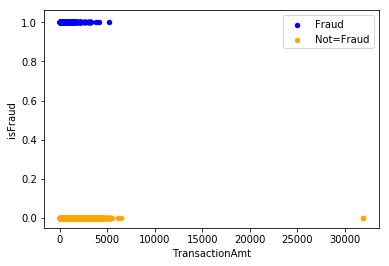

In [7]:
ax = fraud.plot.scatter(x="TransactionAmt", y="isFraud", color='blue', label="Fraud")
not_fraud.plot.scatter(x="TransactionAmt", y="isFraud", color='orange', label="Not=Fraud", ax=ax)

# Data Preprocessing

In [8]:
column_names = train.columns

In [9]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('std')

In [10]:
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)

In [11]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

In [12]:
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [13]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

False

In [14]:
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

84

In [15]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [16]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

In [17]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
#X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)
del train
test = test[["TransactionDT", 'TransactionID']]

In [18]:
# by https://www.kaggle.com/dimartinot
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test )

In [19]:
gc.collect()

0

In [20]:
X.isnull().any().sum()

309

In [21]:
y.isnull().sum()

0

In [22]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props

In [23]:
X = reduce_mem_usage(X)

Memory usage of properties dataframe is : 1667.0211791992188  MB
******************************
Column:  TransactionAmt
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  ProductCD
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  card1
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  card2
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  card3
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  card4
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  card5
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  card6
dtype before:  int64
dtype after:  uint8
***

In [24]:
X_test = reduce_mem_usage(X_test)

Memory usage of properties dataframe is : 1430.3258514404297  MB
******************************
Column:  TransactionAmt
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  ProductCD
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  card1
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  card2
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  card3
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  card4
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  card5
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  card6
dtype before:  int64
dtype after:  uint8
***

In [25]:
null_percent = X.isnull().sum()/X.shape[0]*100

cols_to_drop = np.array(null_percent[null_percent > 50].index)

cols_to_drop

array([], dtype=object)

In [26]:
X = X.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop,axis=1)

In [27]:
null_percent = X_test.isnull().sum()/X.shape[0]*100
null_percent[null_percent > 0]

Series([], dtype: float64)

In [28]:
null_cols = []

for i in null_cols:
    print('data type of {} is {}'.format(i, str(train[i].dtype)))
    train[i] = train[i].replace(np.nan, train[i].mode()[0])
    test[i] = test[i].replace(np.nan, train[i].mode()[0])
    print('Filled the null values of column {}'.format(i))
    print('--------------------------------------------')

In [29]:
X.isnull().any().sum()

0

In [30]:
test = X_test

# Model Building

In [31]:
def normalize(X):
  for feature in X.columns:
    X[feature] -= X[feature].mean()
    X[feature] /= X[feature].std()

    return X

In [32]:
V_values=[]
for i in range(1, 340):
  col = 'V%d' %i
  if col in X.columns:
    V_values.append(col)
features = ['TransactionAmt'] + V_values 

In [33]:
x = X[features]
y = y

In [34]:
model = LogisticRegression(class_weight='balanced', C=1)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.65, random_state=0)

for train_indices, test_indices in splitter.split(x,y):
  X_train, y_train = x.iloc[train_indices], y.iloc[train_indices]
  X_test, y_test = x.iloc[test_indices], y.iloc[test_indices]

  x_train_norm = normalize(X_train)
  x_test_norm = normalize(X_test)

  model.fit(x_train_norm, y_train)
  y_pred_norm = model.predict(x_test_norm)

  print(classification_report(y_pred_norm, y_test))


              precision    recall  f1-score   support

           0       0.76      0.98      0.86    287766
           1       0.63      0.09      0.16     96085

    accuracy                           0.76    383851
   macro avg       0.70      0.54      0.51    383851
weighted avg       0.73      0.76      0.68    383851



In [35]:
confusion_matrix(y_pred_norm, y_test)

array([[282856,   4910],
       [ 87564,   8521]])

In [36]:
test = normalize(test[features])

In [37]:
sample_submission["isFraud"] = model.predict(test)

In [38]:
sample_submission.to_csv("Submission1.csv", index=False)